<a href="https://colab.research.google.com/github/orhanaydinn/brainTumor_Alzheimer_Prediction/blob/main/BrainTumor_Alzheimer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - Uploaded Dataset**

brain_disease_classification_dataset.zip file upload manually.
```
zip_path = "/content/brain_disease_classification_dataset.zip"
extract_path = "/content/brain_disease_classification_dataset"
```
**zip_path** represents the file path of the uploaded ZIP file.

**extract_path** defines the destination directory where the contents of the ZIP file will be extracted.

In [1]:
import zipfile
import os

# File and directory paths to extract
zip_path = "/content/brain_disease_classification_dataset.zip"
extract_path = "/content/brain_disease_classification_dataset"

# Open zip file and extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset successfully extracted to:", extract_path)


Dataset successfully extracted to: /content/brain_disease_classification_dataset


Check the loaded datasets before data preparation process.

In [2]:
for root, dirs, files in os.walk(extract_path):
    print(f"\n{root}")
    for d in dirs:
        print(f"├── {d}")
    for f in files[:5]:
        print(f"├── {f}")


/content/brain_disease_classification_dataset
├── alzheimer
├── tumor

/content/brain_disease_classification_dataset/alzheimer
├── alzheimer_very_mild_demented
├── alzheimer_mild_demented
├── alzheimer_non_demented
├── alzheimer_moderate_demented

/content/brain_disease_classification_dataset/alzheimer/alzheimer_very_mild_demented
├── very_mild_4266.jpg
├── very_mild_3605.jpg
├── very_mild_2371.jpg
├── very_mild_366.jpg
├── very_mild_9225.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_mild_demented
├── mild_8428.jpg
├── mild_5556.jpg
├── mild_391.jpg
├── mild_4185.jpg
├── mild_9631.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_non_demented
├── non_demented_7765.jpg
├── non_demented_4733.jpg
├── non_demented_6695.jpg
├── non_demented_4920.jpg
├── non_demented_12654.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_moderate_demented
├── moderate_5966.jpg
├── moderate_6418.jpg
├── moderate_322.jpg
├── moderate_1411.jpg

**` def show_random_images(dataset_dir, samples=3):`**
This function displays a random 3 sample images from each class.

**`img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`**
cv2 library create BGR images default setting. This code convert BGR to RGB.



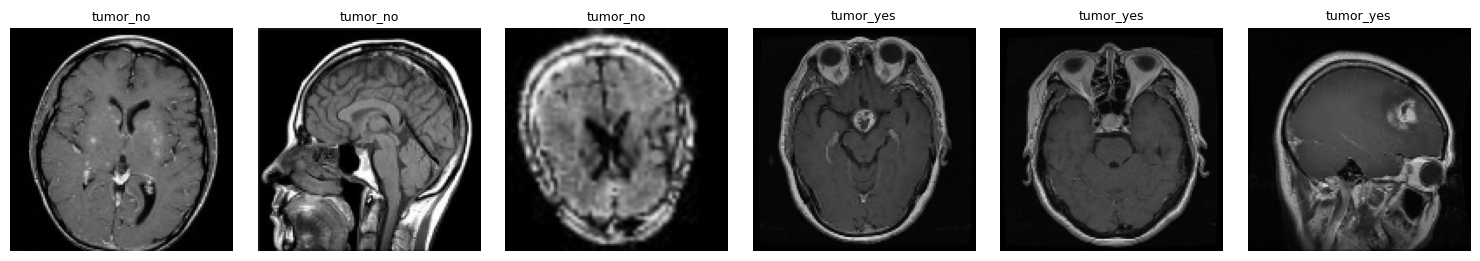

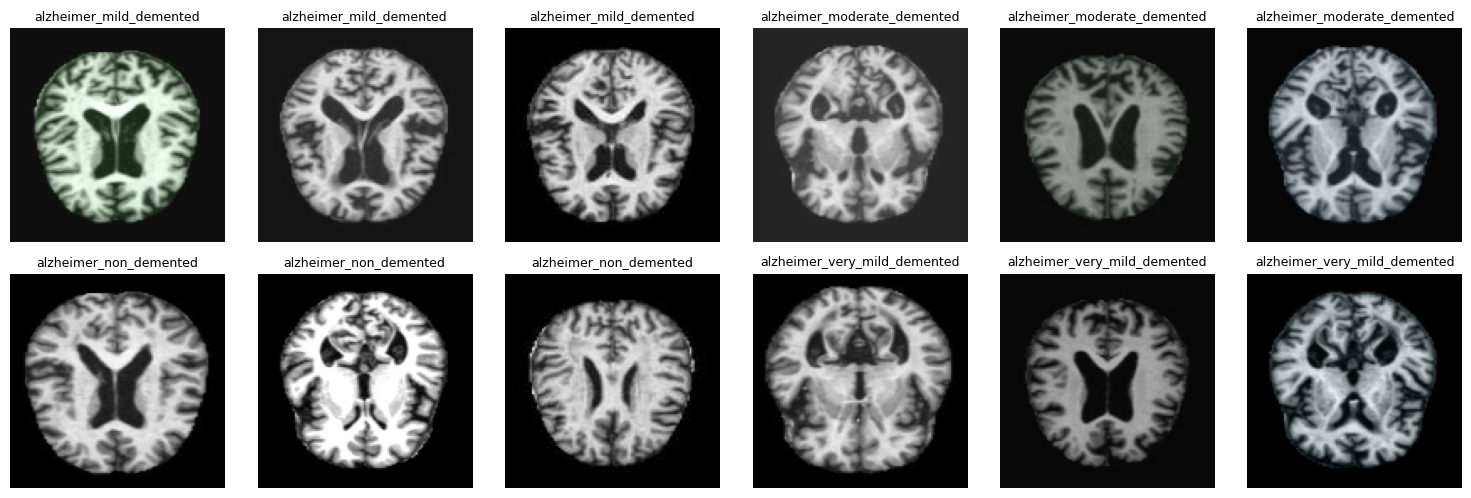

In [3]:
import os
import cv2
import random
import matplotlib.pyplot as plt

IMG_SIZE = 128

def show_random_images(dataset_dir, samples=3):
    class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

    rows = len(class_folders)
    cols = 6
    plt.figure(figsize=(cols * 2.5, rows * 2.5))
    i = 1
    for label in sorted(class_folders):
        class_path = os.path.join(dataset_dir, label)
        images = os.listdir(class_path)
        random.shuffle(images)

        for img_name in images[:samples]:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            plt.subplot(rows, cols, i)
            plt.imshow(img)
            plt.title(label, fontsize=9)
            plt.axis('off')
            i += 1
    plt.tight_layout()
    plt.show()


# Tumor
show_random_images("/content/brain_disease_classification_dataset/tumor")

# Alzheimer
show_random_images("/content/brain_disease_classification_dataset/alzheimer")


Check the dataset size before pre processing.

                              Tumor  Alzheimer
tumor_no                       6000          0
tumor_yes                      6679          0
alzheimer_mild_demented           0       9856
alzheimer_moderate_demented       0       6528
alzheimer_non_demented            0      12800
alzheimer_very_mild_demented      0      11200


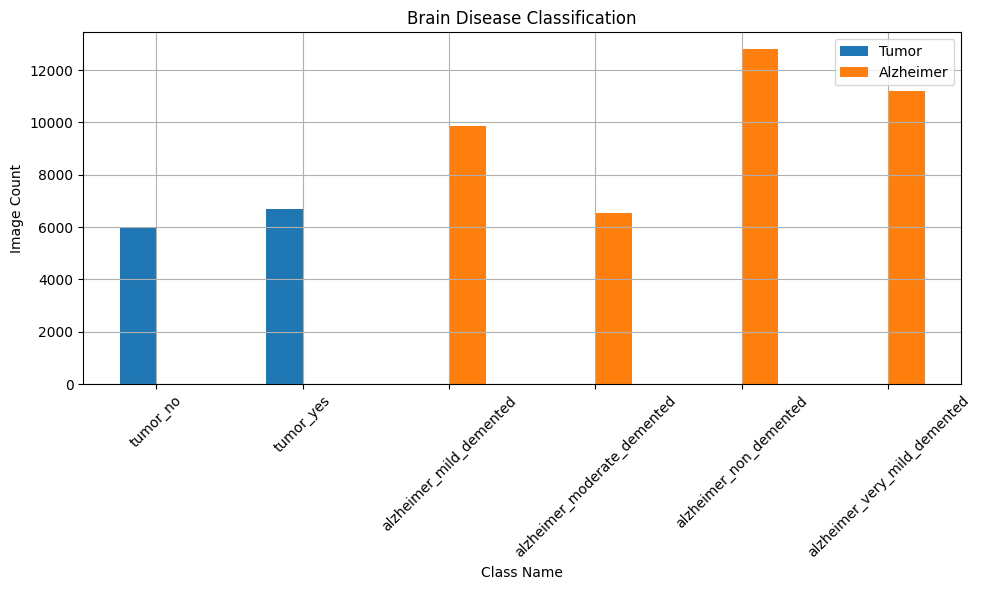

In [4]:
import pandas as pd
import numpy as np

tumor_dir = "/content/brain_disease_classification_dataset/tumor"
alz_dir = "/content/brain_disease_classification_dataset/alzheimer"

def count_images_in_folders(base_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts


tumor_counts = count_images_in_folders(tumor_dir)
alz_counts = count_images_in_folders(alz_dir)


tumor_df = pd.DataFrame.from_dict(tumor_counts, orient='index', columns=['Tumor'])
alz_df = pd.DataFrame.from_dict(alz_counts, orient='index', columns=['Alzheimer'])


df_counts = pd.concat([tumor_df, alz_df], axis=0).fillna(0).astype(int)
print(df_counts)

df_counts.plot(kind="bar", figsize=(10, 6), legend=True)
plt.title("Brain Disease Classification")
plt.ylabel("Image Count")
plt.xlabel("Class Name")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **2 - Tumor Data Preparation & Preprocessing**

In this section, the data was examined and augmentation was applied to some labels.

*   Load and Label Data
*   Read, Resize and Convert Images to Arrays
*   Convert to Numpy Arrays and Normalize the Pixel Values
*   Data Augmentation
    *   Class Distribution Table
    *   Augmentation for **tumor_no** labels
        *   Show Augmentation Images
*   Show Current Dataset




> **Since the models were trained with the latest data, data augmentation was applied already and the dataset was loaded that way. The data augmentation in this section is only representative and is included to show what codes are used.**

## 2.1 - Load and Label Data

**`label_map = {label: idx for idx, label in enumerate(class_names)}`**

This code automatically detects the class folders in the dataset directory and maps each class to a unique integer.

In [5]:
import os

DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"

# Sınıf isimlerini al ve etiketle
class_names = sorted(os.listdir(DATASET_DIR))
label_map = {label: idx for idx, label in enumerate(class_names)}
print("Label Mapping:", label_map)

Label Mapping: {'tumor_no': 0, 'tumor_yes': 1}


## 2.2 - Read, Resize and Convert Images to Arrays

In this project image size is used 64x64 (`IMG_SIZE = 64`) . Therefore, this code `img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))` resize all of images which are differents size.

In [6]:
import os
import cv2
import numpy as np


DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"
IMG_SIZE = 64

class_names = sorted(os.listdir(DATASET_DIR))
label_map = {label: idx for idx, label in enumerate(class_names)}


X = []
y = []

for label in class_names:
    class_path = os.path.join(DATASET_DIR, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            X.append(img)
            y.append(label_map[label])



## 2.3 - Convert to NumPy Arrays & Normalize the Pixel Values

This code block makes the data types available for model training and normalizes the pixel values ​​of the images.

```
X = np.array(X, dtype='float32')
y = np.array(y)
```
Converts the Python lists X and y into NumPy arrays.

In [7]:
X = np.array(X, dtype=np.float32)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (12679, 64, 64, 3)
y shape: (12679,)


## 2.4 - Data Augmentation

### 2.4.1 -  Class Distribution Table

### 2.4.2 - Tumor_NO Augmentation

`target_count = 6000` The target number of images was determined as 6000 and the current number of images was subtracted from this number `to_generate = target_count - current_count`.

`for img_name in tqdm(existing_images):` This function generated the required number of images.

```
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
```


*   Every images was rotated 15°. `rotation_range=15`
*   Zoomed by 10% `zoom_range=0.1`.
*   Slightly shifted horizontally and vertically `width_shift_range=0.1,
height_shift_range=0.1`.
*   Brightness was adjusted between 80% and 120%. `brightness_range=[0.8,1.2]`
*   Some images were flipped horizontally. Empty areas were filled using the nearest pixel method. `horizontal_flip=True, fill_mode='nearest'`


` aug_name = f"aug_tumor_no_{image_idx}.jpg"` This code adds the names **aug_tumor_no_1, aug_tumor_no_2, ..... , aug_tumor_no_n** to the new images

In [8]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Settings
target_count = 6000
input_folder = "/content/brain_disease_classification_dataset/tumor/tumor_no"
IMG_SIZE = 64


existing_images = os.listdir(input_folder)
current_count = len(existing_images)
to_generate = target_count - current_count

print(f"Current: {current_count} — Target: {target_count} — Generating: {to_generate}")


image_idx = 1
for img_name in tqdm(existing_images):
    img_path = os.path.join(input_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.reshape((1, IMG_SIZE, IMG_SIZE, 3))

    aug_iter = datagen.flow(img, batch_size=1, save_to_dir=input_folder, save_prefix=f'aug_tumor_no_{image_idx}', save_format='jpeg')

    for _ in range(2):
        if image_idx > to_generate:
            break
        next(aug_iter)
        image_idx += 1

print("The augmentation process is complete.")


Current: 6000 — Target: 6000 — Generating: 0


100%|██████████| 6000/6000 [00:02<00:00, 2296.37it/s]

The augmentation process is complete.


#### 2.4.2.1 - Show Augmentation Images

Check new augmentation 15 images randomly. `sample_imgs = random.sample(aug_images, min(15, len(aug_images)))`

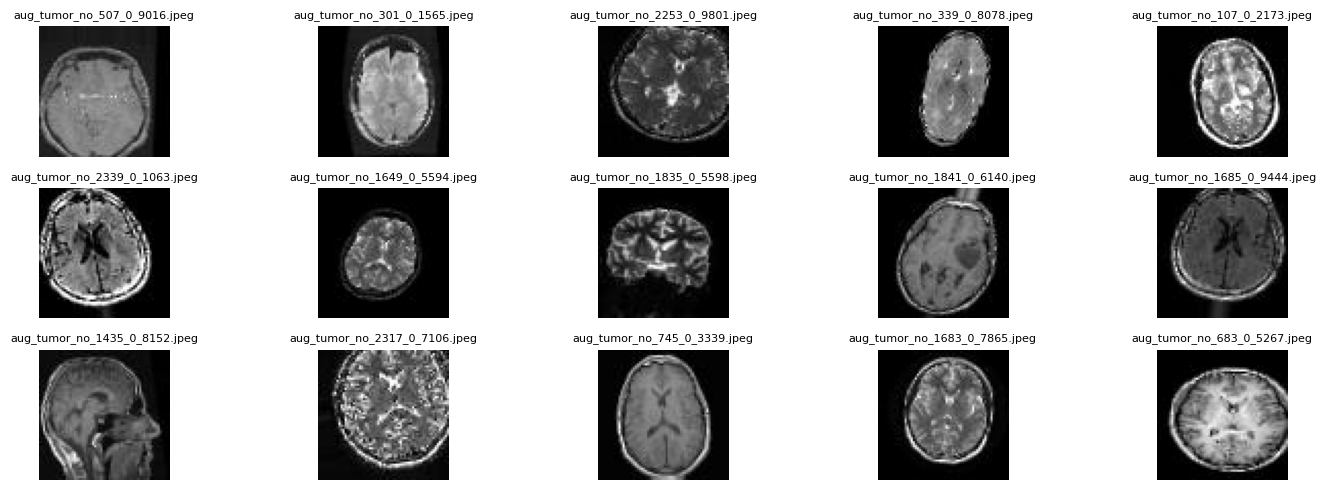

In [9]:
import matplotlib.pyplot as plt
import cv2
import os
import random


augmented_folder = "/content/brain_disease_classification_dataset/tumor/tumor_no"


aug_images = [img for img in os.listdir(augmented_folder) if img.startswith("aug_")]

# Show random 15 images for augmentation
sample_imgs = random.sample(aug_images, min(15, len(aug_images)))


plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(sample_imgs):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


## 2.5 - Show Current Dataset

After the data augmentation, dataset was controlled and created table which are class and image count.

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset path
DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"


class_names = sorted([folder for folder in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, folder))])

# Count images
class_counts = {cls: len([img for img in os.listdir(os.path.join(DATASET_DIR, cls))
                          if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
                for cls in class_names}

# crate Dataframe
df_distribution = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_distribution = df_distribution.sort_values("Image Count", ascending=False)

# show table
df_distribution.reset_index(drop=True, inplace=True)
df_distribution


,Class,Image Count
0,tumor_yes,6679
1,tumor_no,6000


<ipython-input-11-dedaca5b84bf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_distribution, x="Class", y="Image Count", palette="mako")


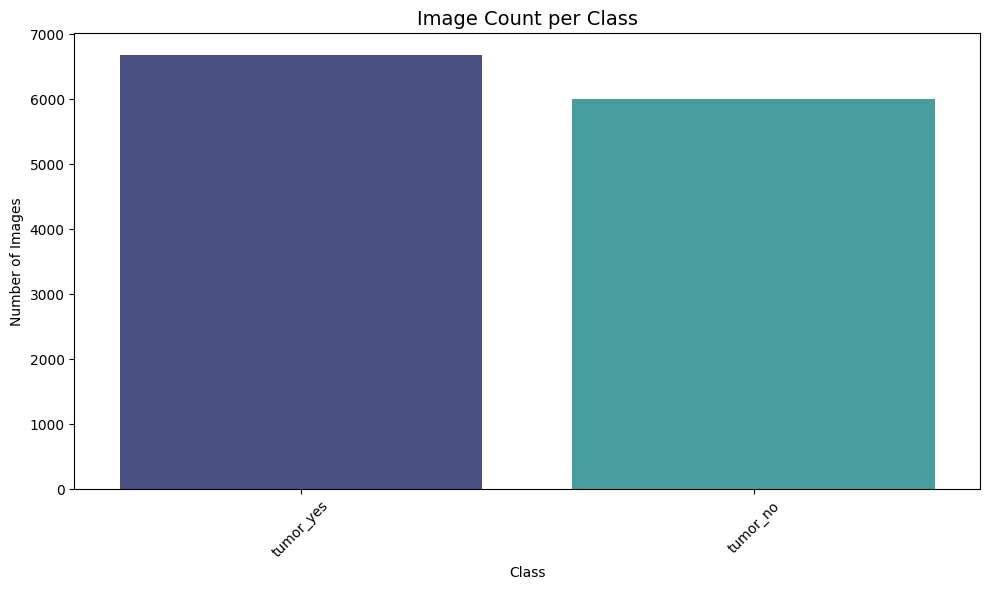

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_distribution, x="Class", y="Image Count", palette="mako")
plt.title("Image Count per Class", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# **3 - Tumor Model Training & Evaluation**

In this section, CNN and ML models are created and compared for **tumor dataset**.

*   Split Data ( Train / Test )
*   CNN Model
*   CNN Model Training
    *   Training Visualization
    *   Confusion Matrix
*   VGG16 - Transfer Learning Model
*   VGG16 - Transfer Learning Model Training



## 3.1 - Split the Data (Train / Test)

The train and test datasets are separated by 20%.

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (10143, 64, 64, 3)
y_train shape: (10143,)


## 3.2 - CNN Model

In [75]:
import time
from tensorflow.keras.callbacks import Callback

class TrainingTimeCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Eğitim zamanı başlangıcını kaydediyoruz
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Eğitim zamanı bitişini kaydediyoruz
        training_time = time.time() - self.start_time
        logs['epoch_training_time'] = training_time
        print(f"Epoch {epoch+1} Training Time: {training_time:.2f} seconds")

        # Logs içine 'training_time' ekliyoruz
        if 'training_times' not in self.model.history.history:
            self.model.history.history['training_times'] = []

        self.model.history.history['training_times'].append(training_time)

# Eğitim sırasında callback'i kullanma
training_time_callback = TrainingTimeCallback()



Base cnn was created for first cnn model.


**CNN - Model Architecture**

```
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
```


*   `Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))` Aconvolutional layer with 32 filters of size 3x3 and ReLU activation.
*   `Conv2D(64, (3, 3), activation='relu')` Reduces spatial dimensions.

*   `Flatten()` Converts the 2D feature maps into a 1D vector for dense layers.

*    `Dense(128, activation='relu'),` A fully connected layer with 128 units and ReLU activation.

*     `Dropout(0.5)` Drops 50% of the neurons to prevent overfitting.

In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # output layer
])



**CNN - Model Compilation**

```
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
```

*   `optimizer='adam'` In this project the Adam optimization algorithm was preferred. Adam automatically adapts the learning rate for each parameter separately using first and second moment estimates. This leads to faster and more stable convergence during training.


In [91]:
# Compile
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # << Doğru olan bu
    metrics=['accuracy']
)


In [92]:
training_time_callback = TrainingTimeCallback()

**CNN - EarlyStopping**
```
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
```
Stops training if validation accuracy does not improve for 5 consecutive epochs. Recovers the best weights.


In [93]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**CNN - Model Checkpoint**

```
model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
```
Saves the model file with the best validation accuracy. The best validation accuracy was saved "**best_cnn_model_tumor.h5**" in this cnn model. This checkpoint will be used directly in the later stages of the project. There is no need to retrain the model each time it is run from the beginning.


In [94]:
# Checkpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [95]:
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 CNN Model Training

**CNN - Time Calculation**

```
import time
start = time.time()


end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

```
Starts a timer to measure how long model training takes. After the training, stops the timer and prints total training time in seconds.


**CNN - Model Training**
```
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)
```



*   `X_train, y_train,` Trains the CNN model using the training data.
*   `epochs=30, batch_size=32` Training was run for 30 epochs, and process 32 images at a time (batch size).
*   `callbacks=[early_stop,` This code can stops training if validation loss doesn’t improve for a few epochs.
*   `callbacks=[  ,model_checkpoint]` Saves the model with the best validation accuracy.
*   `verbose=1` Prints progress of training for each epoch.

In [96]:
import time
start = time.time()

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[training_time_callback, early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7052 - loss: 0.5577Epoch 1 Training Time: 7.02 seconds

Epoch 1: val_accuracy improved from -inf to 0.89511, saving model to best_cnn_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7055 - loss: 0.5573 - val_accuracy: 0.8951 - val_loss: 0.2412 - epoch_training_time: 7.0179
Epoch 2/30
312/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9030 - loss: 0.2468Epoch 2 Training Time: 6.25 seconds

Epoch 2: val_accuracy improved from 0.89511 to 0.94322, saving model to best_cnn_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9031 - loss: 0.2464 - val_accuracy: 0.9432 - val_loss: 0.1439 - epoch_training_time: 6.2497
Epoch 3/30
309/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9468 - loss: 0.1525Epoch 3 Training Time: 1.84 seconds

Epoch 3: val_accuracy improved from 0.94322 to 0.96372, saving model to best_cnn_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9469 - loss: 0.1523 - val_accuracy: 0.9637 - val_loss: 0.1035 - epoch_training_time: 1.8393
Epoch 4/30
309/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9648 - loss: 0.1004Epoch 4 Training Time: 2.00 seconds

Epoch 4: val_accuracy did not improve from 0.96372
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9649 - loss: 0.1001 - val_accuracy: 0.9621 - val_loss: 0.1034 - epoch_training_time: 2.0003
Epoch 5/30
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9798 - loss: 0.0621Epoch 5 Training Time: 2.21 seconds

Epoch 5: val_accuracy improved from 0.96372 to 0.98226, saving model to best_cnn_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9798 - loss: 0.0620 - val_accuracy: 0.9823 - val_loss: 0.0561 - epoch_training_time: 2.2115
Epoch 6/30
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9845 - loss: 0.0440Epoch 6 Training Time: 1.83 seconds

Epoch 6: val_accuracy did not improve from 0.98226
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9846 - loss: 0.0440 - val_accuracy: 0.9803 - val_loss: 0.0673 - epoch_training_time: 1.8277
Epoch 7/30
310/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9908 - loss: 0.0260Epoch 7 Training Time: 1.83 seconds

Epoch 7: val_accuracy improved from 0.98226 to 0.99014, saving model to best_cnn_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9908 - loss: 0.0261 - val_accuracy: 0.9901 - val_loss: 0.0372 - epoch_training_time: 1.8284
Epoch 8/30
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9920 - loss: 0.0245Epoch 8 Training Time: 2.45 seconds

Epoch 8: val_accuracy did not improve from 0.99014
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9920 - loss: 0.0246 - val_accuracy: 0.9850 - val_loss: 0.0482 - epoch_training_time: 2.4469
Epoch 9/30
309/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9930 - loss: 0.0218Epoch 9 Training Time: 2.65 seconds

Epoch 9: val_accuracy improved from 0.99014 to 0.99132, saving model to best_cnn_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9930 - loss: 0.0218 - val_accuracy: 0.9913 - val_loss: 0.0344 - epoch_training_time: 2.6466
Epoch 10/30
308/317 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9957 - loss: 0.0138Epoch 10 Training Time: 2.73 seconds

Epoch 10: val_accuracy did not improve from 0.99132
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9957 - loss: 0.0139 - val_accuracy: 0.9886 - val_loss: 0.0369 - epoch_training_time: 2.7342
Epoch 11/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9904 - loss: 0.0238Epoch 11 Training Time: 1.81 seconds

Epoch 11: val_accuracy did not improve from 0.99132
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9904 - loss: 0.0238 - val_accuracy: 0.9870 - val_loss: 0.0406 - epoch_training_time: 1.8068
Epoch 12/30
311/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0116Epoch 12 Training Time: 1.83 seconds

Epoch 12: val_accuracy improved from 0.99132 to 0.99330, saving model to best_cnn_m

317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9967 - loss: 0.0116 - val_accuracy: 0.9933 - val_loss: 0.0326 - epoch_training_time: 1.8280
Epoch 13/30
312/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9931 - loss: 0.0201Epoch 13 Training Time: 2.46 seconds

Epoch 13: val_accuracy improved from 0.99330 to 0.99369, saving model to best_cnn_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9931 - loss: 0.0200 - val_accuracy: 0.9937 - val_loss: 0.0317 - epoch_training_time: 2.4574
Epoch 14/30
312/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0238Epoch 14 Training Time: 1.92 seconds

Epoch 14: val_accuracy did not improve from 0.99369
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9947 - loss: 0.0236 - val_accuracy: 0.9874 - val_loss: 0.0451 - epoch_training_time: 1.9189
Epoch 15/30
311/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9971 - loss: 0.0084Epoch 15 Training Time: 2.69 seconds

Epoch 15: val_accuracy did not improve from 0.99369
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9970 - loss: 0.0085 - val_accuracy: 0.9874 - val_loss: 0.0470 - epoch_training_time: 2.6896
Epoch 16/30
311/317 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0151Epoch 16 Training Time: 1.96 seconds

Epoch 16: val_accuracy did not improve from 0.99369
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s

**CNN Model Training Summary**

The model completed its learning in approximately 38 minutes. It completed the learning process in the 30th epoch and achieved the best result in the 26th epoch.

### 3.3.1 CNN Model Training Visualization

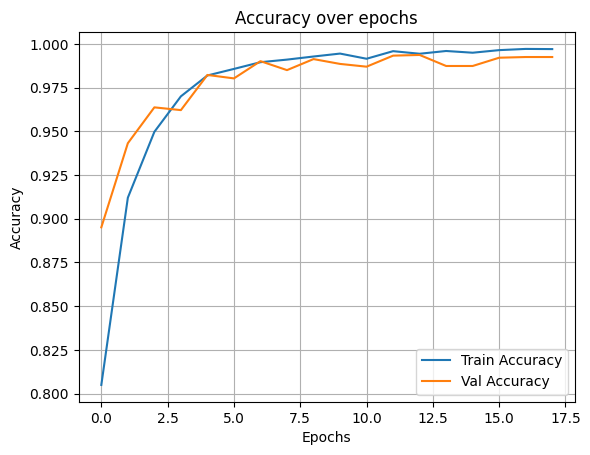

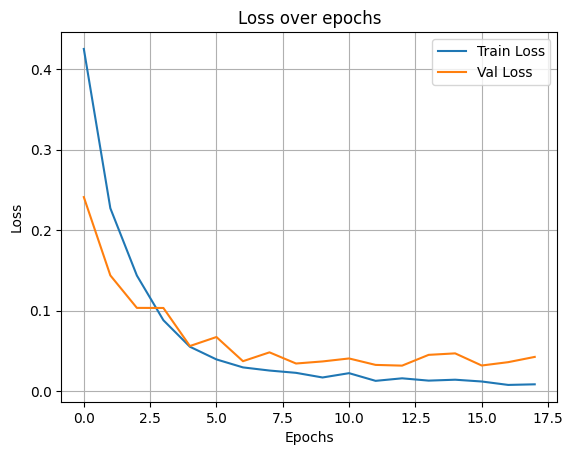

In [97]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 3.3.2 Confusion Matrix for CNN Model

Confusion matrix was used for estimation calculation.

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_cnn_model_tumor.h5")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


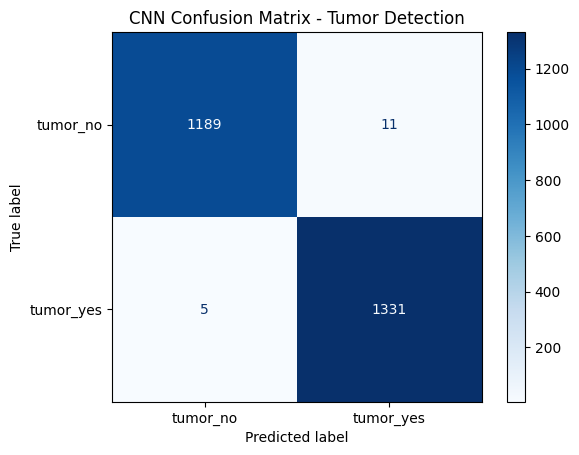

CNN Classification Report:

              precision    recall  f1-score   support

    tumor_no       1.00      0.99      0.99      1200
   tumor_yes       0.99      1.00      0.99      1336

    accuracy                           0.99      2536
   macro avg       0.99      0.99      0.99      2536
weighted avg       0.99      0.99      0.99      2536



In [99]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("CNN Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("CNN Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))


## 3.4 - VGG16 - Transfer Learning Model

VGG16 Transfer Learning was created for another deep learning model.

**VGG16 - Model Architecture**
*   `base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))` Loads the VGG16 model pre-trained on ImageNet without the top layer. The input shape is set to 64x64 RGB images.


In [100]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add last layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


model_vgg16 = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False


**VGG16 - Model Compilation**

In [101]:
# Compile
model_vgg16.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [102]:
training_time_callback = TrainingTimeCallback()

**VGG16 - Earlystop**

In [103]:
# Earlystop
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**VGG16 - Model Checkpoint**

Saves the model file with the best validation accuracy. The best validation accuracy was saved "**best_vgg16_model_tumor.h5**" in this vgg16 model.

In [104]:
# Model Checkpoint
model_checkpoint = ModelCheckpoint(
    'best_vgg16_model_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [106]:
model_vgg16.summary()

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 3.5 - VGG16 - Transfer Learning Model Training

**Model Training - Time Calculation**

In [107]:
import time
start = time.time()

history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    callbacks=[training_time_callback, early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/40
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7402 - loss: 0.4977Epoch 1 Training Time: 13.11 seconds

Epoch 1: val_accuracy improved from -inf to 0.86830, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.7404 - loss: 0.4974 - val_accuracy: 0.8683 - val_loss: 0.3012 - epoch_training_time: 13.1149
Epoch 2/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8711 - loss: 0.3033Epoch 2 Training Time: 9.00 seconds

Epoch 2: val_accuracy improved from 0.86830 to 0.89669, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8712 - loss: 0.3032 - val_accuracy: 0.8967 - val_loss: 0.2381 - epoch_training_time: 8.9972
Epoch 3/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9066 - loss: 0.2461Epoch 3 Training Time: 8.06 seconds

Epoch 3: val_accuracy improved from 0.89669 to 0.91956, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9066 - loss: 0.2461 - val_accuracy: 0.9196 - val_loss: 0.2056 - epoch_training_time: 8.0602
Epoch 4/40
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9152 - loss: 0.2217Epoch 4 Training Time: 10.14 seconds

Epoch 4: val_accuracy improved from 0.91956 to 0.93257, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9152 - loss: 0.2217 - val_accuracy: 0.9326 - val_loss: 0.1807 - epoch_training_time: 10.1394
Epoch 5/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9298 - loss: 0.1906Epoch 5 Training Time: 10.01 seconds

Epoch 5: val_accuracy improved from 0.93257 to 0.94006, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9298 - loss: 0.1906 - val_accuracy: 0.9401 - val_loss: 0.1595 - epoch_training_time: 10.0068
Epoch 6/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9439 - loss: 0.1591Epoch 6 Training Time: 8.06 seconds

Epoch 6: val_accuracy improved from 0.94006 to 0.94440, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9438 - loss: 0.1592 - val_accuracy: 0.9444 - val_loss: 0.1446 - epoch_training_time: 8.0636
Epoch 7/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9372 - loss: 0.1673Epoch 7 Training Time: 11.04 seconds

Epoch 7: val_accuracy improved from 0.94440 to 0.94558, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9372 - loss: 0.1672 - val_accuracy: 0.9456 - val_loss: 0.1375 - epoch_training_time: 11.0371
Epoch 8/40
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9436 - loss: 0.1481Epoch 8 Training Time: 10.03 seconds

Epoch 8: val_accuracy improved from 0.94558 to 0.94834, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9436 - loss: 0.1481 - val_accuracy: 0.9483 - val_loss: 0.1260 - epoch_training_time: 10.0251
Epoch 9/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9516 - loss: 0.1338Epoch 9 Training Time: 9.00 seconds

Epoch 9: val_accuracy improved from 0.94834 to 0.95110, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9516 - loss: 0.1339 - val_accuracy: 0.9511 - val_loss: 0.1235 - epoch_training_time: 8.9976
Epoch 10/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9520 - loss: 0.1328Epoch 10 Training Time: 8.00 seconds

Epoch 10: val_accuracy improved from 0.95110 to 0.95899, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9520 - loss: 0.1327 - val_accuracy: 0.9590 - val_loss: 0.1076 - epoch_training_time: 8.0007
Epoch 11/40
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9563 - loss: 0.1166Epoch 11 Training Time: 11.13 seconds

Epoch 11: val_accuracy did not improve from 0.95899
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9563 - loss: 0.1166 - val_accuracy: 0.9547 - val_loss: 0.1199 - epoch_training_time: 11.1259
Epoch 12/40
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9519 - loss: 0.1221Epoch 12 Training Time: 9.24 seconds

Epoch 12: val_accuracy improved from 0.95899 to 0.96057, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9520 - loss: 0.1221 - val_accuracy: 0.9606 - val_loss: 0.0978 - epoch_training_time: 9.2403
Epoch 13/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9640 - loss: 0.1026Epoch 13 Training Time: 8.05 seconds

Epoch 13: val_accuracy improved from 0.96057 to 0.96609, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9639 - loss: 0.1026 - val_accuracy: 0.9661 - val_loss: 0.0955 - epoch_training_time: 8.0547
Epoch 14/40
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9614 - loss: 0.1048Epoch 14 Training Time: 11.03 seconds

Epoch 14: val_accuracy improved from 0.96609 to 0.96727, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9614 - loss: 0.1048 - val_accuracy: 0.9673 - val_loss: 0.0919 - epoch_training_time: 11.0322
Epoch 15/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9587 - loss: 0.1041Epoch 15 Training Time: 10.05 seconds

Epoch 15: val_accuracy did not improve from 0.96727
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9587 - loss: 0.1041 - val_accuracy: 0.9641 - val_loss: 0.0913 - epoch_training_time: 10.0546
Epoch 16/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9629 - loss: 0.0964Epoch 16 Training Time: 8.00 seconds

Epoch 16: val_accuracy improved from 0.96727 to 0.97319, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9629 - loss: 0.0964 - val_accuracy: 0.9732 - val_loss: 0.0820 - epoch_training_time: 8.0027
Epoch 17/40
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9650 - loss: 0.0871Epoch 17 Training Time: 11.15 seconds

Epoch 17: val_accuracy did not improve from 0.97319
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9650 - loss: 0.0871 - val_accuracy: 0.9700 - val_loss: 0.0882 - epoch_training_time: 11.1525
Epoch 18/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9648 - loss: 0.0959Epoch 18 Training Time: 9.00 seconds

Epoch 18: val_accuracy did not improve from 0.97319
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9648 - loss: 0.0959 - val_accuracy: 0.9673 - val_loss: 0.0917 - epoch_training_time: 9.0046
Epoch 19/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9696 - loss: 0.0846Epoch 19 Training Time: 9.00 seconds

Epoch 19: val_accuracy did not improve from 0.97319
317/317 ━━━━━━━━━━━━━━

317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9656 - loss: 0.0889 - val_accuracy: 0.9752 - val_loss: 0.0727 - epoch_training_time: 9.3457
Epoch 21/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9719 - loss: 0.0800Epoch 21 Training Time: 10.02 seconds

Epoch 21: val_accuracy did not improve from 0.97516
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9719 - loss: 0.0800 - val_accuracy: 0.9649 - val_loss: 0.0922 - epoch_training_time: 10.0209
Epoch 22/40
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9708 - loss: 0.0783Epoch 22 Training Time: 10.25 seconds

Epoch 22: val_accuracy improved from 0.97516 to 0.97831, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9708 - loss: 0.0783 - val_accuracy: 0.9783 - val_loss: 0.0711 - epoch_training_time: 10.2466
Epoch 23/40
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9768 - loss: 0.0658Epoch 23 Training Time: 10.99 seconds

Epoch 23: val_accuracy improved from 0.97831 to 0.98028, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9768 - loss: 0.0659 - val_accuracy: 0.9803 - val_loss: 0.0617 - epoch_training_time: 10.9883
Epoch 24/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9730 - loss: 0.0727Epoch 24 Training Time: 8.08 seconds

Epoch 24: val_accuracy did not improve from 0.98028
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9730 - loss: 0.0727 - val_accuracy: 0.9803 - val_loss: 0.0622 - epoch_training_time: 8.0796
Epoch 25/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9757 - loss: 0.0655Epoch 25 Training Time: 8.04 seconds

Epoch 25: val_accuracy did not improve from 0.98028
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9757 - loss: 0.0655 - val_accuracy: 0.9712 - val_loss: 0.0773 - epoch_training_time: 8.0351
Epoch 26/40
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9748 - loss: 0.0695Epoch 26 Training Time: 10.27 seconds

Epoch 26: val_accuracy improved from 0.98028 to 0.98068, saving model to b

317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9748 - loss: 0.0695 - val_accuracy: 0.9807 - val_loss: 0.0571 - epoch_training_time: 10.2748
Epoch 27/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9757 - loss: 0.0670Epoch 27 Training Time: 8.04 seconds

Epoch 27: val_accuracy did not improve from 0.98068
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9757 - loss: 0.0669 - val_accuracy: 0.9807 - val_loss: 0.0574 - epoch_training_time: 8.0434
Epoch 28/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9812 - loss: 0.0560Epoch 28 Training Time: 11.29 seconds

Epoch 28: val_accuracy improved from 0.98068 to 0.98423, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9812 - loss: 0.0560 - val_accuracy: 0.9842 - val_loss: 0.0516 - epoch_training_time: 11.2852
Epoch 29/40
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9756 - loss: 0.0642Epoch 29 Training Time: 8.99 seconds

Epoch 29: val_accuracy did not improve from 0.98423
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9756 - loss: 0.0642 - val_accuracy: 0.9787 - val_loss: 0.0616 - epoch_training_time: 8.9932
Epoch 30/40
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9827 - loss: 0.0561Epoch 30 Training Time: 9.35 seconds

Epoch 30: val_accuracy did not improve from 0.98423
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9827 - loss: 0.0562 - val_accuracy: 0.9826 - val_loss: 0.0572 - epoch_training_time: 9.3546
Epoch 31/40
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9779 - loss: 0.0585Epoch 31 Training Time: 11.21 seconds

Epoch 31: val_accuracy did not improve from 0.98423
317/317 ━━━━━━━━━━━━━━

### 3.5.1 - VGG16 Model Training Visualization

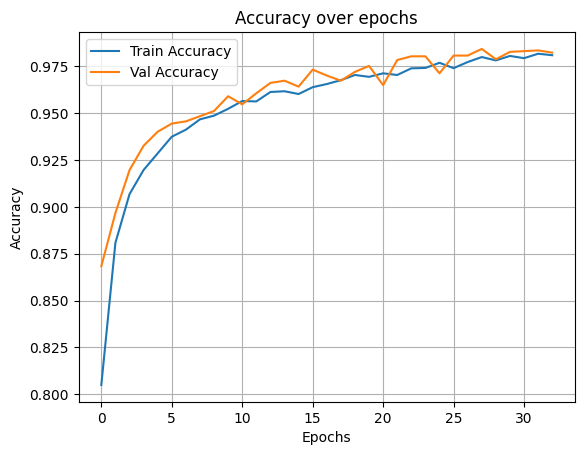

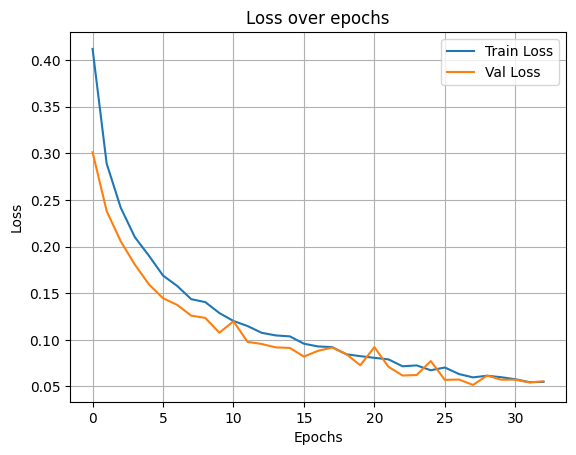

In [108]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3.5.2 VGG16 Model Confusion Matrix

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_vgg16_model_tumor.h5")

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


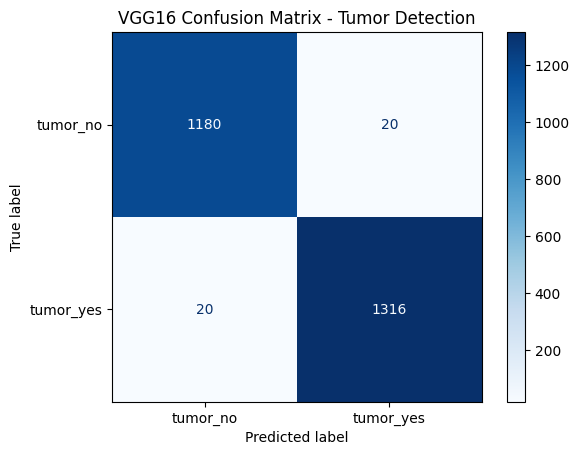

VGG16 Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.98      0.98      0.98      1200
   tumor_yes       0.99      0.99      0.99      1336

    accuracy                           0.98      2536
   macro avg       0.98      0.98      0.98      2536
weighted avg       0.98      0.98      0.98      2536



In [110]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("VGG16 Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("VGG16 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))

## 3.6 - EfficientNetB0 - Transfer Learning Model

EfficientNetB0 Transfer Learning was created for another deep learning model.

**EfficientNetB0  - Model Architecture**
*   `base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))` Loads the EfficientNetB0 model pre-trained on ImageNet without the top layer. The input shape is set to 64x64 RGB images.


In [111]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Binary classification output


model_efficientnet = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False

**EfficientNetB0 - Model Compilation**

Adam optimizer was used but early stopping function stopped model training at epoch 6 and Epoch 1 was selected as the best model. Therefore, optimizer function was changed.

*   `learning_rate = 0.0001` learning rate value is decreased to increase learning.

In [112]:
learning_rate = 0.0001  # Learning rate value
optimizer = Adam(learning_rate=learning_rate)


model_efficientnet.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [113]:
training_time_callback = TrainingTimeCallback()

**EfficientNetB0 - Early Stop**

In [114]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**EfficientNetB0 - Checkpoint**

In [115]:
# Checkpoint
model_checkpoint = ModelCheckpoint(
    'best_efficientnet_model_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [116]:
model_efficientnet.summary()

Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 64, 64, 3)      │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 3.7 - EfficientNetB0 - Transfer Learning Model Training

**Model Training - Time Calculation**

In [117]:
import time
start = time.time()

history_efficientnet = model_efficientnet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[training_time_callback, early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4970 - loss: 0.7043Epoch 1 Training Time: 41.66 seconds

Epoch 1: val_accuracy improved from -inf to 0.52681, saving model to best_efficientnet_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.4970 - loss: 0.7043 - val_accuracy: 0.5268 - val_loss: 0.6920 - epoch_training_time: 41.6556
Epoch 2/30
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5237 - loss: 0.6931Epoch 2 Training Time: 3.09 seconds

Epoch 2: val_accuracy did not improve from 0.52681
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5236 - loss: 0.6931 - val_accuracy: 0.5268 - val_loss: 0.6917 - epoch_training_time: 3.0857
Epoch 3/30
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5224 - loss: 0.6919Epoch 3 Training Time: 6.06 seconds

Epoch 3: val_accuracy did not improve from 0.52681
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5224 - loss: 0.6919 - val_accuracy: 0.5268 - val_loss: 0.6917 - epoch_training_time: 6.0565
Epoch 4/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5140 - loss: 0.6928Epoch 4 Training Time: 4.10 seconds

Epoch 4: val_accuracy did not improve from 0.52681
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 10m

### 3.7.1 - EfficientNetB0 Training Visualization

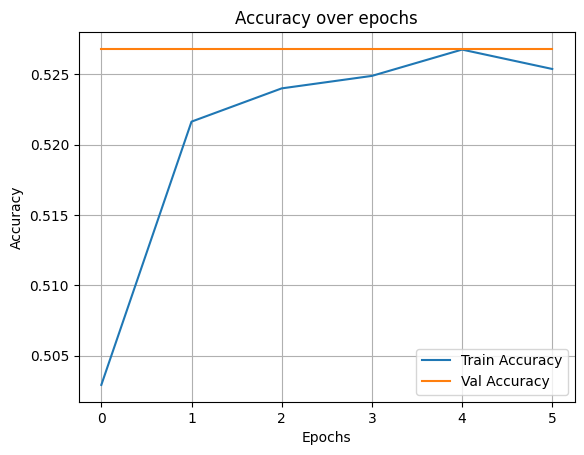

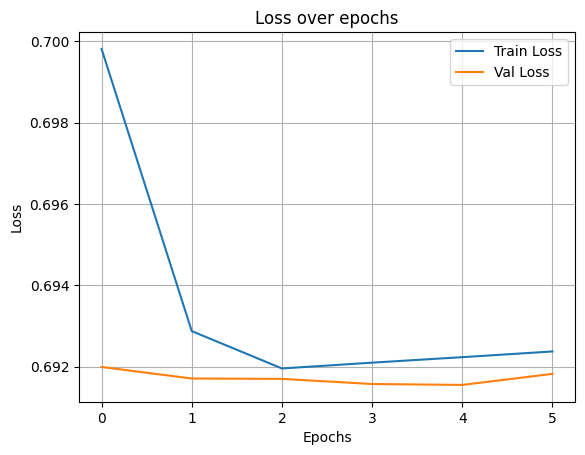

In [119]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3.7.2 - EfficientNetB0 Confusion Matrix

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_efficientnet_model_tumor.h5")

80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step


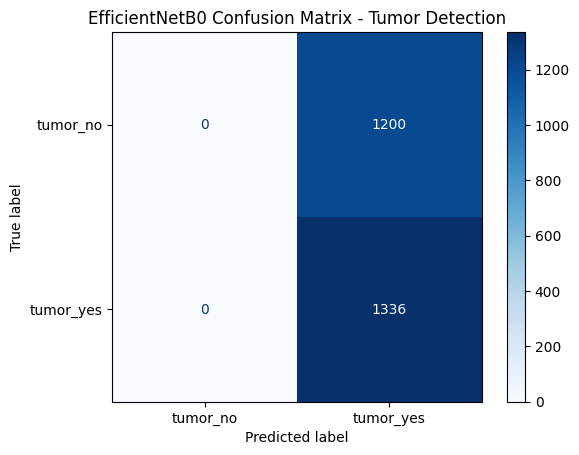

EfficientNetB0 Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.00      0.00      0.00      1200
   tumor_yes       0.53      1.00      0.69      1336

    accuracy                           0.53      2536
   macro avg       0.26      0.50      0.35      2536
weighted avg       0.28      0.53      0.36      2536



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [121]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("EfficientNetB0 Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("EfficientNetB0 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))

## 3.8 - ResNet50 - Transfer Learning Model

 ResNet50 Transfer Learning was created for another deep learning model.

**ResNet50  - Model Architecture**
*   base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))` Loads the EfficientNetB0 model pre-trained on ImageNet without the top layer. The input shape is set to 64x64 RGB images.

In [122]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


model_resnet50 = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False

**ResNet50 - Model Compilation**

In [123]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [124]:
training_time_callback = TrainingTimeCallback()

**ResNet50 - Early Stop**

In [125]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**ResNet50 - Checkpoint**

In [126]:
model_checkpoint = ModelCheckpoint(
    'best_resnet50_model_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [127]:
model_resnet50.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 3.9 - ResNet50 - Transfer Learning Model Training

**Model Training - Time Calculation**

In [128]:
import time
start = time.time()

history_resnet50 = model_resnet50.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[training_time_callback, early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5345 - loss: 0.7184Epoch 1 Training Time: 25.60 seconds

Epoch 1: val_accuracy improved from -inf to 0.66640, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.5346 - loss: 0.7183 - val_accuracy: 0.6664 - val_loss: 0.6372 - epoch_training_time: 25.5967
Epoch 2/50
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6482 - loss: 0.6394Epoch 2 Training Time: 7.03 seconds

Epoch 2: val_accuracy improved from 0.66640 to 0.72397, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6483 - loss: 0.6394 - val_accuracy: 0.7240 - val_loss: 0.5997 - epoch_training_time: 7.0325
Epoch 3/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7091 - loss: 0.5993Epoch 3 Training Time: 5.68 seconds

Epoch 3: val_accuracy improved from 0.72397 to 0.72634, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7091 - loss: 0.5992 - val_accuracy: 0.7263 - val_loss: 0.5723 - epoch_training_time: 5.6788
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7305 - loss: 0.5702Epoch 4 Training Time: 5.50 seconds

Epoch 4: val_accuracy improved from 0.72634 to 0.74014, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7305 - loss: 0.5702 - val_accuracy: 0.7401 - val_loss: 0.5511 - epoch_training_time: 5.5032
Epoch 5/50
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7353 - loss: 0.5552Epoch 5 Training Time: 8.98 seconds

Epoch 5: val_accuracy improved from 0.74014 to 0.75710, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7354 - loss: 0.5551 - val_accuracy: 0.7571 - val_loss: 0.5346 - epoch_training_time: 8.9750
Epoch 6/50
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7458 - loss: 0.5375Epoch 6 Training Time: 9.82 seconds

Epoch 6: val_accuracy did not improve from 0.75710
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7458 - loss: 0.5375 - val_accuracy: 0.7461 - val_loss: 0.5229 - epoch_training_time: 9.8224
Epoch 7/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7527 - loss: 0.5179Epoch 7 Training Time: 5.24 seconds

Epoch 7: val_accuracy improved from 0.75710 to 0.75868, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7527 - loss: 0.5179 - val_accuracy: 0.7587 - val_loss: 0.5158 - epoch_training_time: 5.2408
Epoch 8/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7561 - loss: 0.5175Epoch 8 Training Time: 4.95 seconds

Epoch 8: val_accuracy did not improve from 0.75868
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7562 - loss: 0.5173 - val_accuracy: 0.7571 - val_loss: 0.5045 - epoch_training_time: 4.9529
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7707 - loss: 0.4965Epoch 9 Training Time: 5.24 seconds

Epoch 9: val_accuracy improved from 0.75868 to 0.76459, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7707 - loss: 0.4965 - val_accuracy: 0.7646 - val_loss: 0.4966 - epoch_training_time: 5.2375
Epoch 10/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7704 - loss: 0.4882Epoch 10 Training Time: 4.90 seconds

Epoch 10: val_accuracy improved from 0.76459 to 0.76735, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7704 - loss: 0.4882 - val_accuracy: 0.7674 - val_loss: 0.4908 - epoch_training_time: 4.9021
Epoch 11/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7788 - loss: 0.4873Epoch 11 Training Time: 5.41 seconds

Epoch 11: val_accuracy improved from 0.76735 to 0.77208, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7787 - loss: 0.4872 - val_accuracy: 0.7721 - val_loss: 0.4847 - epoch_training_time: 5.4055
Epoch 12/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7804 - loss: 0.4773Epoch 12 Training Time: 9.25 seconds

Epoch 12: val_accuracy improved from 0.77208 to 0.77603, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7804 - loss: 0.4773 - val_accuracy: 0.7760 - val_loss: 0.4777 - epoch_training_time: 9.2499
Epoch 13/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7815 - loss: 0.4710Epoch 13 Training Time: 9.60 seconds

Epoch 13: val_accuracy did not improve from 0.77603
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7815 - loss: 0.4710 - val_accuracy: 0.7756 - val_loss: 0.4744 - epoch_training_time: 9.6043
Epoch 14/50
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7777 - loss: 0.4694Epoch 14 Training Time: 10.11 seconds

Epoch 14: val_accuracy improved from 0.77603 to 0.78115, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7777 - loss: 0.4694 - val_accuracy: 0.7812 - val_loss: 0.4684 - epoch_training_time: 10.1072
Epoch 15/50
313/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7897 - loss: 0.4579Epoch 15 Training Time: 9.68 seconds

Epoch 15: val_accuracy improved from 0.78115 to 0.78628, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7896 - loss: 0.4579 - val_accuracy: 0.7863 - val_loss: 0.4626 - epoch_training_time: 9.6757
Epoch 16/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7950 - loss: 0.4553Epoch 16 Training Time: 5.54 seconds

Epoch 16: val_accuracy improved from 0.78628 to 0.78707, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7950 - loss: 0.4553 - val_accuracy: 0.7871 - val_loss: 0.4584 - epoch_training_time: 5.5357
Epoch 17/50
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7952 - loss: 0.4463Epoch 17 Training Time: 9.46 seconds

Epoch 17: val_accuracy improved from 0.78707 to 0.78864, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7952 - loss: 0.4463 - val_accuracy: 0.7886 - val_loss: 0.4568 - epoch_training_time: 9.4645
Epoch 18/50
313/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8009 - loss: 0.4469Epoch 18 Training Time: 5.37 seconds

Epoch 18: val_accuracy did not improve from 0.78864
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8009 - loss: 0.4469 - val_accuracy: 0.7879 - val_loss: 0.4507 - epoch_training_time: 5.3671
Epoch 19/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8028 - loss: 0.4417Epoch 19 Training Time: 5.04 seconds

Epoch 19: val_accuracy improved from 0.78864 to 0.79574, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8027 - loss: 0.4417 - val_accuracy: 0.7957 - val_loss: 0.4449 - epoch_training_time: 5.0381
Epoch 20/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8029 - loss: 0.4379Epoch 20 Training Time: 5.19 seconds

Epoch 20: val_accuracy improved from 0.79574 to 0.79614, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8029 - loss: 0.4378 - val_accuracy: 0.7961 - val_loss: 0.4411 - epoch_training_time: 5.1876
Epoch 21/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8021 - loss: 0.4343Epoch 21 Training Time: 9.80 seconds

Epoch 21: val_accuracy improved from 0.79614 to 0.79929, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8021 - loss: 0.4343 - val_accuracy: 0.7993 - val_loss: 0.4390 - epoch_training_time: 9.7957
Epoch 22/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8089 - loss: 0.4299Epoch 22 Training Time: 5.24 seconds

Epoch 22: val_accuracy improved from 0.79929 to 0.80442, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8089 - loss: 0.4299 - val_accuracy: 0.8044 - val_loss: 0.4334 - epoch_training_time: 5.2379
Epoch 23/50
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8078 - loss: 0.4263Epoch 23 Training Time: 9.60 seconds

Epoch 23: val_accuracy improved from 0.80442 to 0.80994, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8078 - loss: 0.4263 - val_accuracy: 0.8099 - val_loss: 0.4287 - epoch_training_time: 9.5967
Epoch 24/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8116 - loss: 0.4225Epoch 24 Training Time: 9.26 seconds

Epoch 24: val_accuracy did not improve from 0.80994
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8116 - loss: 0.4225 - val_accuracy: 0.7981 - val_loss: 0.4263 - epoch_training_time: 9.2602
Epoch 25/50
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8129 - loss: 0.4218Epoch 25 Training Time: 5.34 seconds

Epoch 25: val_accuracy improved from 0.80994 to 0.81427, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8129 - loss: 0.4218 - val_accuracy: 0.8143 - val_loss: 0.4267 - epoch_training_time: 5.3364
Epoch 26/50
313/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8159 - loss: 0.4144Epoch 26 Training Time: 9.70 seconds

Epoch 26: val_accuracy improved from 0.81427 to 0.81979, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8159 - loss: 0.4144 - val_accuracy: 0.8198 - val_loss: 0.4199 - epoch_training_time: 9.7027
Epoch 27/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8167 - loss: 0.4080Epoch 27 Training Time: 5.48 seconds

Epoch 27: val_accuracy did not improve from 0.81979
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8167 - loss: 0.4081 - val_accuracy: 0.8194 - val_loss: 0.4159 - epoch_training_time: 5.4768
Epoch 28/50
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8264 - loss: 0.3948Epoch 28 Training Time: 10.36 seconds

Epoch 28: val_accuracy did not improve from 0.81979
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8263 - loss: 0.3949 - val_accuracy: 0.8139 - val_loss: 0.4149 - epoch_training_time: 10.3649
Epoch 29/50
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8275 - loss: 0.4034Epoch 29 Training Time: 10.00 seconds

Epoch 29: val_accuracy did not improve from 0.81979
317/317 ━━━━━━━━━━━━

317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8201 - loss: 0.4036 - val_accuracy: 0.8249 - val_loss: 0.4111 - epoch_training_time: 9.9739
Epoch 31/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8206 - loss: 0.4053Epoch 31 Training Time: 9.39 seconds

Epoch 31: val_accuracy did not improve from 0.82492
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8207 - loss: 0.4053 - val_accuracy: 0.8245 - val_loss: 0.4055 - epoch_training_time: 9.3852
Epoch 32/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8348 - loss: 0.3870Epoch 32 Training Time: 5.23 seconds

Epoch 32: val_accuracy improved from 0.82492 to 0.82689, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8348 - loss: 0.3870 - val_accuracy: 0.8269 - val_loss: 0.4040 - epoch_training_time: 5.2313
Epoch 33/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8265 - loss: 0.4015Epoch 33 Training Time: 4.98 seconds

Epoch 33: val_accuracy improved from 0.82689 to 0.83123, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8266 - loss: 0.4014 - val_accuracy: 0.8312 - val_loss: 0.4006 - epoch_training_time: 4.9809
Epoch 34/50
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8341 - loss: 0.3933Epoch 34 Training Time: 9.74 seconds

Epoch 34: val_accuracy did not improve from 0.83123
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8340 - loss: 0.3933 - val_accuracy: 0.8214 - val_loss: 0.4000 - epoch_training_time: 9.7391
Epoch 35/50
313/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8340 - loss: 0.3811Epoch 35 Training Time: 10.32 seconds

Epoch 35: val_accuracy did not improve from 0.83123
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8340 - loss: 0.3812 - val_accuracy: 0.8289 - val_loss: 0.3953 - epoch_training_time: 10.3224
Epoch 36/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8371 - loss: 0.3793Epoch 36 Training Time: 9.81 seconds

Epoch 36: val_accuracy did not improve from 0.83123
317/317 ━━━━━━━━━━━━━

317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8329 - loss: 0.3854 - val_accuracy: 0.8336 - val_loss: 0.3907 - epoch_training_time: 5.3085
Epoch 38/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8407 - loss: 0.3800Epoch 38 Training Time: 9.18 seconds

Epoch 38: val_accuracy did not improve from 0.83360
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8407 - loss: 0.3800 - val_accuracy: 0.8332 - val_loss: 0.3905 - epoch_training_time: 9.1808
Epoch 39/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8456 - loss: 0.3735Epoch 39 Training Time: 10.03 seconds

Epoch 39: val_accuracy did not improve from 0.83360
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8456 - loss: 0.3736 - val_accuracy: 0.8320 - val_loss: 0.3894 - epoch_training_time: 10.0289
Epoch 40/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8337 - loss: 0.3809Epoch 40 Training Time: 10.15 seconds

Epoch 40: val_accuracy did not improve from 0.83360
317/317 ━━━━━━━━━━━━━

317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8476 - loss: 0.3665 - val_accuracy: 0.8431 - val_loss: 0.3804 - epoch_training_time: 5.3041
Epoch 43/50
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8468 - loss: 0.3682Epoch 43 Training Time: 9.22 seconds

Epoch 43: val_accuracy did not improve from 0.84306
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8468 - loss: 0.3682 - val_accuracy: 0.8391 - val_loss: 0.3797 - epoch_training_time: 9.2229
Epoch 44/50
313/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8425 - loss: 0.3751Epoch 44 Training Time: 10.09 seconds

Epoch 44: val_accuracy did not improve from 0.84306
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8426 - loss: 0.3750 - val_accuracy: 0.8383 - val_loss: 0.3778 - epoch_training_time: 10.0885
Epoch 45/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8478 - loss: 0.3606Epoch 45 Training Time: 10.08 seconds

Epoch 45: val_accuracy did not improve from 0.84306
317/317 ━━━━━━━━━━━━━

317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8471 - loss: 0.3624 - val_accuracy: 0.8462 - val_loss: 0.3716 - epoch_training_time: 5.3292
Epoch 48/50
315/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8556 - loss: 0.3548Epoch 48 Training Time: 5.06 seconds

Epoch 48: val_accuracy improved from 0.84621 to 0.84779, saving model to best_resnet50_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8555 - loss: 0.3549 - val_accuracy: 0.8478 - val_loss: 0.3700 - epoch_training_time: 5.0567
Epoch 49/50
314/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8533 - loss: 0.3542Epoch 49 Training Time: 5.32 seconds

Epoch 49: val_accuracy did not improve from 0.84779
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8533 - loss: 0.3543 - val_accuracy: 0.8466 - val_loss: 0.3676 - epoch_training_time: 5.3232
Epoch 50/50
313/317 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8527 - loss: 0.3526Epoch 50 Training Time: 10.08 seconds

Epoch 50: val_accuracy did not improve from 0.84779
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8527 - loss: 0.3526 - val_accuracy: 0.8446 - val_loss: 0.3673 - epoch_training_time: 10.0770
Restoring model weights from the end of the best epoch: 50.
Training time: 7 minutes 16 seconds


### 3.9.1 - ResNet50 Training Visualization

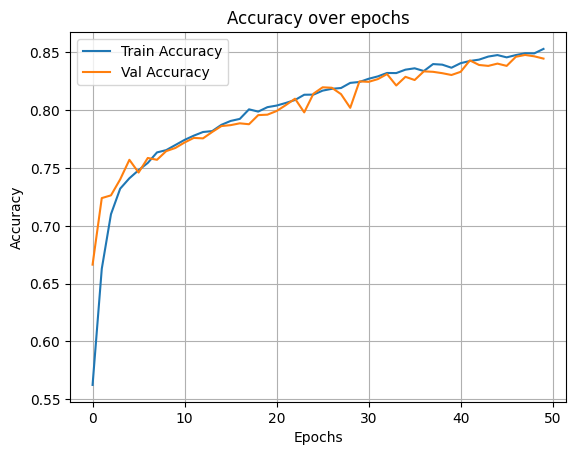

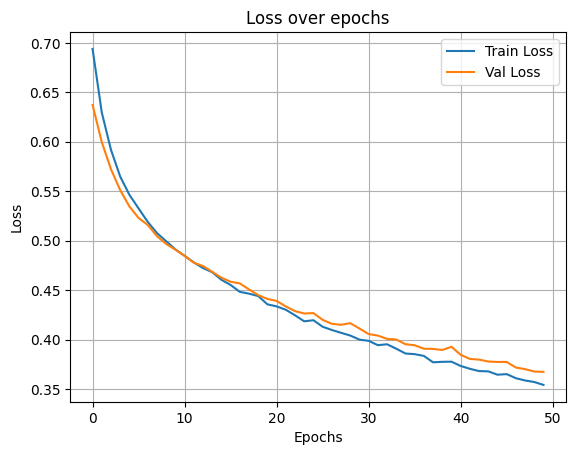

In [129]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_resnet50.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_resnet50.history['loss'], label='Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3.9.2 - ResNet50 Confusion Matrix

In [134]:
def get_model_performance(model, X_test, y_test):
    # Modeli test verisi ile değerlendiriyoruz
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Eğitim süresi verilerini alıyoruz
    training_times = model.history.history.get('training_times', [])
    avg_training_time = sum(training_times) / len(training_times) if training_times else 'N/A'

    return {
        'Model': model_resnet50,  # Modelin ismi
        'Accuracy': accuracy,
        'Loss': loss,
        'Average Training Time (s)': avg_training_time
    }

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_resnet50_model_tumor.h5")

80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step


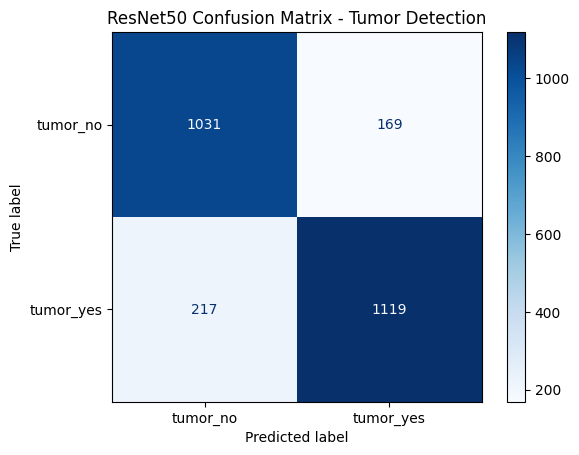

ResNet50 Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.83      0.86      0.84      1200
   tumor_yes       0.87      0.84      0.85      1336

    accuracy                           0.85      2536
   macro avg       0.85      0.85      0.85      2536
weighted avg       0.85      0.85      0.85      2536



In [131]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("ResNet50 Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("ResNet50 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))

## 3.10 - Compare All Models

,Model,Accuracy,Loss,Validation Accuracy,Validation Loss,Training Time (m)
0,CNN,0.997,0.009,0.993,0.043,49s
1,VGG16,0.981,0.055,0.982,0.056,5m 24s
2,EfficientNet,0.525,0.692,0.527,0.692,1m 5s
3,ResNet50,0.853,0.354,0.845,0.367,7m 16s


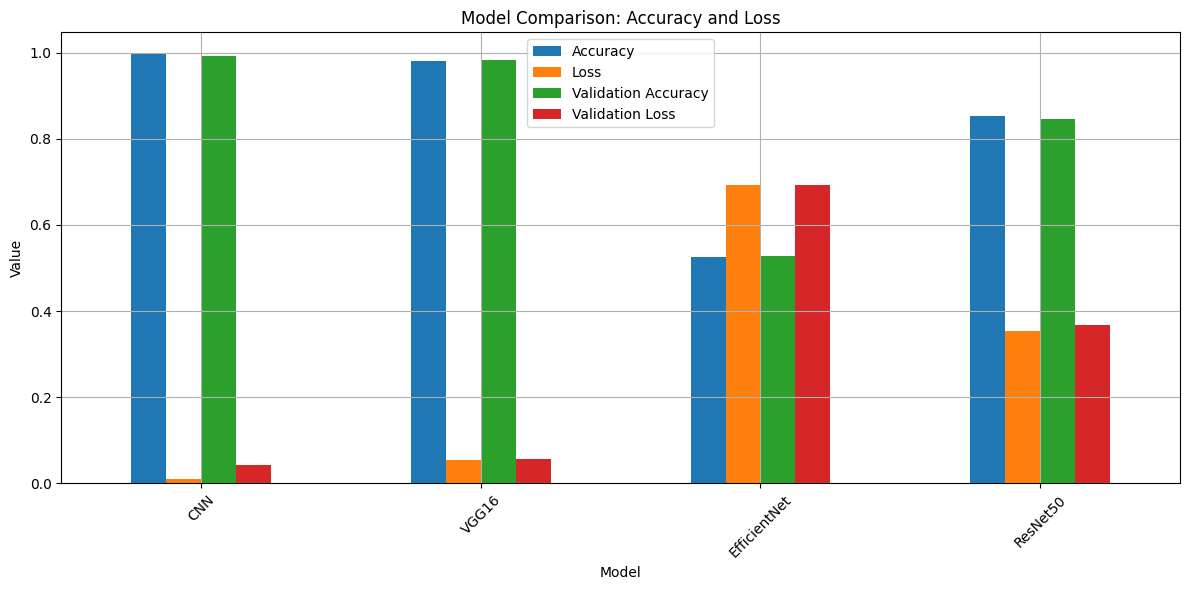

In [185]:
import pandas as pd
from tensorflow.keras.models import load_model


model_paths = {
    'CNN': '/content/best_cnn_model_tumor.h5',
    'VGG16': '/content/best_vgg16_model_tumor.h5',
    'EfficientNet': '/content/best_efficientnet_model_tumor.h5',
    'ResNet50': '/content/best_resnet50_model_tumor.h5',
}


model_histories = {
    'CNN': history_cnn,
    'VGG16': history_vgg16,
    'EfficientNet': history_efficientnet,
    'ResNet50': history_resnet50
}



model_comparisons = []


for model_name, model_path in model_paths.items():



    history = model_histories[model_name].history



    accuracy = round(history.get('accuracy', [None])[-1], 3)
    loss =  round(history.get('loss', ['N/A'])[-1], 3)
    val_accuracy = round(history.get('val_accuracy', ['N/A'])[-1], 3)
    val_loss = round(history.get('val_loss', ['N/A'])[-1], 3)


    if model_name == 'CNN':
        training_time = '49s'
    elif model_name == 'VGG16':
        training_time = '5m 24s'
    elif model_name == 'EfficientNet':
        training_time = '1m 5s'
    elif model_name == 'ResNet50':
        training_time = '7m 16s'


    model_comparisons.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Loss': loss,
        'Validation Accuracy': val_accuracy,
        'Validation Loss': val_loss,
        'Training Time (m)': training_time
    })


df_comparison = pd.DataFrame(model_comparisons)


display(df_comparison)


df_comparison.set_index('Model')[['Accuracy', 'Loss', 'Validation Accuracy','Validation Loss']].plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison: Accuracy and Loss")
plt.ylabel("Value")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()